In [197]:
from utils import (adstock)
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [198]:

# Load data from the 'dataset' sheet, range B6:CY266, with 'Date' as the date column
df_data = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='DataSet',
    usecols='B:CZ',
    skiprows=5,
    nrows=261,
    parse_dates=['Date']
).set_index('Date')

# Add a random number column
df_data['random'] = np.random.rand(len(df_data))
sigma = 0.05
df_data['error'] = scipy.stats.norm.ppf(df_data['random'], loc=0, scale=sigma)

In [199]:
df_var_spec_all = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='EqnSpec',
    usecols='A:G',
) #.set_index('variable')

# Filter, rename 'Beta_Log' to 'Beta', and convert 'Log' column: only 1 is True, anything else is False
df_var_spec_all = df_var_spec_all.rename(columns={'beta_log': 'beta'})
df_var_spec = df_var_spec_all[df_var_spec_all['beta'].notnull()].copy()
df_var_spec['log'] = df_var_spec['log'] == 1
df_var_spec


,variable,beta,carryover,log,group,decomp_ref,spend_variable
0,C,1.200000e+01,NaN,False,base,NaN,NaN
2,D_JAN,-1.500000e-01,NaN,False,base,NaN,NaN
3,D_FEB,-1.000000e-01,NaN,False,base,NaN,NaN
4,D_MAR,8.000000e-02,NaN,False,base,NaN,NaN
5,D_APR,1.000000e-01,NaN,False,base,NaN,NaN
6,D_MAY,1.000000e-01,NaN,False,base,NaN,NaN
10,D_SEP,5.000000e-02,NaN,False,base,NaN,NaN
11,D_OCT,1.000000e-01,NaN,False,base,NaN,NaN
12,D_NOV,1.500000e-01,NaN,False,base,NaN,NaN
13,D_DEC,-2.000000e-01,NaN,False,base,NaN,NaN


In [200]:
def create_transformed_tables(df_data, df_var_spec, log_dep_var = False):
    """
    For each variable in df_var_spec, apply adstock (if carryover is not None), 
    then multiply by beta. Returns df_trans and df_values tables, with df_values including an 'actual' column summing each row.
    If 'normalize' is True in var spec, applies mean normalization: (x - mean) / (max - min)
    """
    df_trans = pd.DataFrame(index=df_data.index)
    df_values = pd.DataFrame(index=df_data.index)
    for _, row in df_var_spec.iterrows():
        var = row['variable']
        if var in df_data.columns:
            series = df_data[var].values.copy()
            # Apply adstock if carryover is not None and not NaN
            if row.get('carryover') is not None and not pd.isnull(row['carryover']):
                series = adstock(series, row['carryover'])
            # # Apply s_curve if saturation and inflection are not None and not NaN
            # if (row.get('saturation') is not None and not pd.isnull(row['saturation']) and
            #     row.get('inflection') is not None and not pd.isnull(row['inflection'])):
            #     series = s_curve(series, row['saturation'], row['inflection'], row['height'])
           

            if (row.get('log') is not None and not pd.isnull(row['log']) and
                row['log'] == True):
                series = np.log(series)


            # # Mean normalization if 'normalize' is True
            # if (row.get('normalize') is not None and not pd.isnull(row['normalize']) and
            #     row['normalize'] == True):
            #     mean = np.mean(series)
            #     max_ = np.max(series)
            #     min_ = np.min(series)
            #     denom = max_ - min_
            #     # Avoid division by zero
            #     if denom == 0:
            #         norm_series = series - mean
            #     else:
            #         # norm_series = (series - mean) / denom
            #         norm_series = (series) / denom ## use this as otherwise get weird confidence range

            #     series = norm_series
            # df_trans_norm[var] = series

            df_trans[var] = series
            # Multiply by beta
            beta_val = row['beta'] if not pd.isnull(row['beta']) else 1
            df_values[var] = df_trans[var] * beta_val
        else:
            # If column missing, fill with NaN
            df_trans[var] = np.nan
            df_values[var] = np.nan
    # Add 'actual' column as row sum
    df_values['model'] = df_values.sum(axis=1)
    if log_dep_var:
        # Log transform the dependent variable if specified
        df_values['model'] = np.exp(df_values['model'])
    
    df_values['actual'] = df_values['model'] * (1+ df_data['error'])
    return df_trans, df_values

In [217]:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec,True)


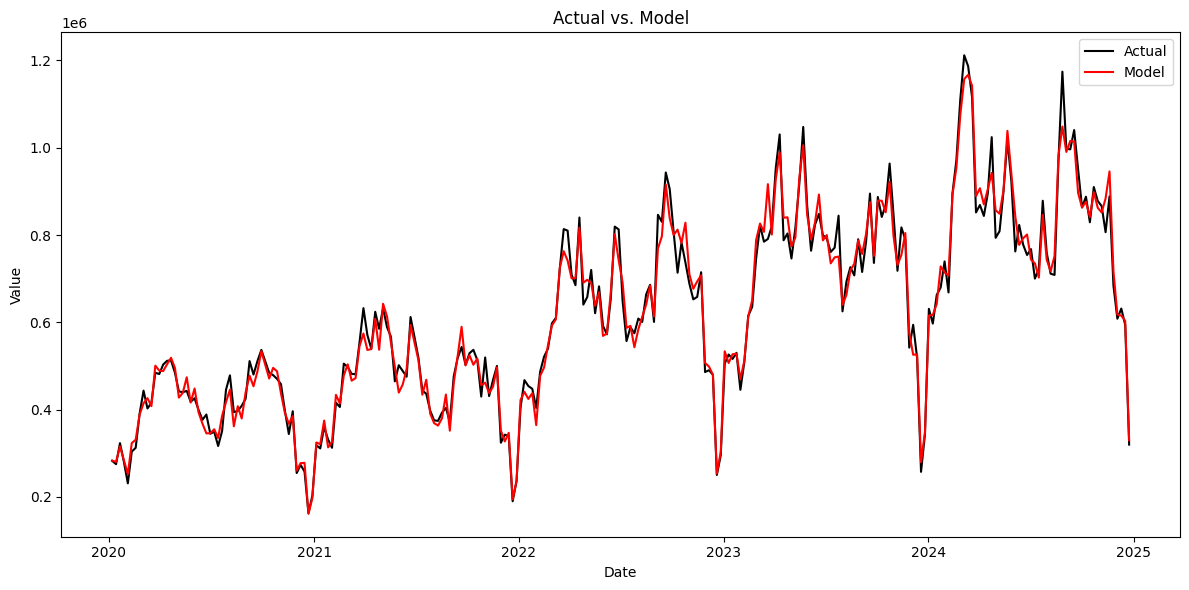

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_values.index, df_values['actual'], label='Actual', color='black')
plt.plot(df_values.index, df_values['model'], label='Model', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Model')
plt.legend()
plt.tight_layout()
plt.show()

,C,D_JAN,D_FEB,D_MAR,D_APR,D_MAY,D_SEP,D_OCT,D_NOV,D_DEC,...,m_Wow_OLV,m_Wow_Social,m_Amaze_Tot,m_Celeb_TV,m_Celeb_Outdoor,m_Celeb_Display,comp_Lor_Tot,comp_no7_Tot,model,actual
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-07,12.0,-0.150000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.001977,-0.002056,283234.081999,291100.772524
2020-01-14,12.0,-0.150000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.002312,-0.002700,280166.758101,272028.973855
2020-01-21,12.0,-0.150000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000437,-0.002958,315891.365040,322120.959975
2020-01-28,12.0,-0.085714,-0.042857,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.001292,-0.004492,284152.028567,287227.643858
2020-02-04,12.0,-0.000000,-0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.005062,-0.003191,251999.124478,259608.507922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,12.0,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.085714,-0.085714,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,717353.783208,710398.436705
2024-12-03,12.0,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,617861.535574,618192.370547
2024-12-10,12.0,-0.000000,-0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,615532.146357,626676.792958


In [240]:
def decomposition(df_var_spec, df_values):
    """
    Decompose the model into variable contributions for each date.
    Returns a DataFrame df_decomp with each variable's contribution and a 'total' column.
    """
    dc = df_values.copy()
    # Sum all columns except the last two in dc
    var_cols = df_var_spec['variable'].tolist()
    # Sum all columns except the last two in dc
    dc['model'] = dc[var_cols].sum(axis=1)
    dc['actual'] = np.log(dc['actual'])
    # Populate dc2 based on decomp_ref in df_var_spec
    dc2 = dc.copy()
    dc2['ref_sum'] = 0
    for _, row in df_var_spec.iterrows():
        var = row['variable']
        if var in dc2.columns and 'decomp_ref' in row and not pd.isnull(row['decomp_ref']):
            series = dc2[var]
            ref_type = str(row['decomp_ref']).lower()
            if ref_type == 'min':
                ref_val = series.min()
                dc2[var] = series - ref_val
                dc2['ref_sum'] += ref_val
            elif ref_type == 'max':
                ref_val = series.max()
                dc2[var] = series - ref_val
                dc2['ref_sum'] += ref_val
            elif ref_type == 'average':
                ref_val = series.mean()
                dc2[var] = series - ref_val
                dc2['ref_sum'] += ref_val

    # # Check that the sum of dc2 columns in var_spec plus ref_sum equals the model column
    # var_cols = [row['variable'] for _, row in df_var_spec.iterrows() if row['variable'] in dc2.columns]

    dc2['var_sum_plus_ref'] = dc2[var_cols].sum(axis=1) + dc2['ref_sum']
    check_equal = np.allclose(dc2['var_sum_plus_ref'], dc['model'])
    print('Check passed:', check_equal)

    dc2['check']=dc2['var_sum_plus_ref'] - dc['model']
    dc2['check'].sum()

    # Create dc3 by grouping dc2 columns into the matching group in var_spec, with ref_sum in 'base'
    group_map = {row['variable']: row['group'] for _, row in df_var_spec.iterrows() if row['variable'] in dc2.columns and 'group' in row}
    grouped_cols = {}
    for var, group in group_map.items():
        if group not in grouped_cols:
            grouped_cols[group] = []
        grouped_cols[group].append(var)
    grouped_cols['base'].append('ref_sum')  # Ensure 'base' group includes ref_sum
    groups = list(grouped_cols.keys())
    dc3 = pd.DataFrame(index=dc2.index)
    for group, cols in grouped_cols.items():
        dc3[group] = dc2[cols].sum(axis=1)


    # Cross-check the sum equals the model column
    dc3['model'] = dc3.sum(axis=1)
    check_equal = np.allclose(dc3['model'], dc['model'])
    print('Group sum check passed:', check_equal)

    dc4 = pd.DataFrame(index=dc3.index)
    dc4['base'] = np.exp(dc3['base'])
    model = np.exp(dc3['model'])
    model_col='model'
    for col in dc3.columns:
        if col not in ['base', model_col]:
            dc4[col] = model - np.exp(dc3[model_col] - dc3[col])

    # Sum all columns except 'model' and 'sum' to get model1
    dc4['model1'] = dc4[groups].sum(axis=1)
    dc4['model'] = np.exp(dc3['model'])
    dc4['diff'] = dc4['model'] - dc4['model1']

    # Create df_decomp by apportioning diff in dc4 across variables (excluding model1, Model1, model), then add apportioned diff to dc4 values using abs(var_cols) div abs_sum * diff
    exclude_cols = ['model1', 'Model1', 'model', 'diff']
    var_cols = [col for col in dc4.columns if col not in exclude_cols]
    abs_sum = dc4[var_cols].abs().sum(axis=1)
    apportioned = dc4[var_cols].abs().div(abs_sum, axis=0).multiply(dc4['diff'], axis=0)
    apportioned = apportioned.fillna(0)  # In case of division by zero
    dc5 = dc4[var_cols] + apportioned
    dc5['model'] = dc5.sum(axis=1)
    dc5['model_og'] = df_values['model']
    dc5['diff'] = dc5['model'] - dc5['model_og']

    check_equal = np.allclose(dc5['model'], dc5['model_og'])
    print('Check passed:', check_equal)
    df_decomp = dc5.copy()
    return df_decomp


In [244]:
df_decomp_vol = decomposition(df_var_spec,df_values)
price_col = 'Price_SE_XF'
df_decomp_val = df_decomp.multiply(df_data[price_col], axis=0)

Check passed: True
Group sum check passed: True
Check passed: True


In [250]:
def calc_roi(df_decomp, df_var_spec,df_data):
    # For each variable in df_decomp that has a value in the spend_variable column in df_var_spec,
    # create a table dividing the sum of the value in df_decomp by the sum of the variable in df_data.

    # Get mapping of variable to spend_variable (non-null only)
    spend_map = df_var_spec[['variable', 'spend_variable']].dropna()

    results = []
    for _, row in spend_map.iterrows():        
        var = row['variable']
        spend_var = row['spend_variable']
        # Only proceed if var is in df_decomp columns and spend_var is in df_data columns
        if var in df_decomp.columns and spend_var in df_data.columns:
            decomp_sum = df_decomp[var].sum()
            spend_sum = df_data[spend_var].sum()
            roi = decomp_sum / spend_sum if spend_sum != 0 else float('nan')
            results.append({'variable': var, 'value': decomp_sum, 'spend_sum': spend_sum, 'roi': roi})

    return pd.DataFrame(results)

In [251]:
df_rois = calc_roi(df_decomp_val, df_var_spec, df_data)

In [252]:
# Show df_rois with formatted numbers: spend_sum and value as integers, roi with two decimals
if 'df_rois' in locals():
    df_rois_fmt = df_rois.copy()
    df_rois_fmt['spend_sum'] = df_rois_fmt['spend_sum'].apply(lambda x: f"{int(round(x)):,}")
    df_rois_fmt['value'] = df_rois_fmt['value'].apply(lambda x: f"{int(round(x)):,}")
    df_rois_fmt['roi'] = df_rois_fmt['roi'].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else '')
    display(df_rois_fmt)
else:
    print('df_rois not found')

,variable,value,spend_sum,roi
0,m_Wow_TV,"1,319,453","2,699,491",0.49
1,m_Wow_OLV,"744,425","947,317",0.79
2,m_Wow_Social,"244,677","121,919",2.01
3,m_Amaze_Tot,"2,847,997","7,929,905",0.36
4,m_Celeb_TV,"2,670,490","2,828,021",0.94
5,m_Celeb_Outdoor,"1,102,906","1,290,619",0.85
6,m_Celeb_Display,"4,695,497","1,586,718",2.96
